In [1]:
import torch
import numpy as np
import math
import os
import matplotlib.pyplot as plt

In [2]:
num_notes = 128
num_time_shifts = 100
num_velocities = 32
message_dim = 2*num_notes + num_velocities + num_time_shifts
instrument_numbers = [0, 6, 40, 41, 42, 43, 45, 60, 68, 70, 71, 73]
num_instruments = len(instrument_numbers)

In [ ]:
###### Music Transformer version of our network ######
# Uses the relative position representation from the Music Transformer


# HuangMHA: multi-headed attention using relative position representation
# (specifically, the representation introduced by Shaw and optimized by Huang)

In [120]:
##### TransformerXL version of our network #####

# Baseline Transformer definition
Uses absolute position representation

In [3]:
# Taken from https://pytorch.org/tutorials/beginner/transformer_tutorial.html.
# Only change is the view/expand in forward (accounts for multiple instruments and batches)
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=10000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.shape[0], :].view(x.shape[0], 1, 1, -1).expand(-1, x.shape[1], x.shape[2], -1)
        return self.dropout(x)
        

# EnsembleTransformer: takes a history of MIDI messages 
# for instruments in an ensemble and generates a distribution for the next message
# for a specific instrument
class EnsembleTransformer(torch.nn.Module):
    # CONSTRUCTOR
    # ARGUMENTS
    # message_dim: dimension of a MIDI message
    # embed_dim: dimension of message embedding
    # num_instruments: number of instrument labels
    # heads: number of attention heads
    # attention_layers: number of attention layers
    # ff_size: size of the feedforward output at the end of the decoder
    def __init__(self, message_dim, embed_dim, num_instruments, heads, attention_layers, ff_size):
        super(EnsembleTransformer, self).__init__()
        
        self.embed_dim = embed_dim
        
        # We add the tanhed instrument embedding to each input message 
        # (this is the global conditioning idea from DeepJ, which comes from WaveNet)
        self.i_embedding = torch.nn.Embedding(num_instruments, embed_dim)
        
        self.position_encoding = PositionalEncoding(embed_dim)
        
        self.embedding = torch.nn.Embedding(message_dim, embed_dim)
        
        # An encoder is used to transform histories of all instruments in the ensemble
        # except the instrument we're generating music for
        encoder_layer = torch.nn.TransformerEncoderLayer(embed_dim, heads, ff_size)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer, attention_layers)
        
        # A decoder is used to transform the history of the instrument we're generating
        # music for, then combine this with the encoder output to generate the next message
        decoder_layer = torch.nn.TransformerDecoderLayer(embed_dim, heads, ff_size)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, attention_layers)
        
        self.logits = torch.nn.Linear(embed_dim, message_dim)
    
    # forward: generates a probability distribution for the next MIDI message
    # for an instrument, given the message history of the ensemble
    # ARGUMENTS
    # history: an LxNxB tensor, where L is the length of the longest history in
    # the batch, N is the max number of instruments in the batch, and B is the batch size. As we
    # walk along the first dimension, we should see indices of MIDI events for a particular
    # instrument
    # mask: an LxNxB tensor, containing True where a message or instrument doesn't exist
    # instruments: a 1xNxB tensor indicating the instrument numbers for each batch
    # gen_idx: a length B tensor indicating the index of the instrument we want to generate music
    # for, for each batch
    # t: which index of the decoder output do we want (along dimension 0)?
    # RETURN: a BxD tensor, representing the distribution for
    # the next MIDI message for the instrument indicated by gen_idx. 
    # Note, to get the actual probabilities you'll have to take the softmax
    # of this tensor along dimension 1
    def forward(self, history, mask, instruments, gen_idx, t):
        L = history.shape[0] # longest length
        N = history.shape[1] # max instruments
        B = history.shape[2] # batch size
        assert(instruments.shape == (1, N, B))
        assert(mask.shape == history.shape)
        assert(gen_idx.shape == (B,))
        
        inputs = self.embedding(history) + torch.tanh(self.i_embedding(instruments)).expand(L, -1, -1, -1)
        
        inputs = self.position_encoding(inputs)
        
        encoder_mask = None
        
        # If only one instrument, only run the decoder
        if N == 1:
            encoding = torch.zeros((1, B, self.embed_dim))
        else:
            encode_idx = torch.tensor([[i for i in range(N) if i != gen_idx[b]] for b in range(B)])
            encode_idx = encode_idx.transpose(0, 1).unsqueeze(0).expand(L, -1, -1)
            encoder_inputs = torch.gather(inputs, 1, encode_idx.unsqueeze(3).expand(-1, -1, -1, self.embed_dim)).view(-1, B, self.embed_dim)

            encoder_mask = torch.gather(mask, 1, encode_idx).view(-1, B).transpose(0, 1)
            encoding = self.encoder(encoder_inputs, src_key_padding_mask=encoder_mask)
        
        decode_idx = gen_idx.view(1, 1, -1).expand(L, -1, -1)
        decoder_inputs = torch.gather(inputs, 1, decode_idx.unsqueeze(3).expand(-1, -1, -1, self.embed_dim)).squeeze(1)
        decoder_mask = torch.gather(mask, 1, decode_idx).squeeze(1).transpose(0, 1)
        
        # TODO: do I need the memory_key_padding_mask? I think so, because some of the encoder outputs are from padding values
        decoding = self.decoder(decoder_inputs, encoding, tgt_key_padding_mask=decoder_mask, memory_key_padding_mask=encoder_mask)
        
        return self.logits(decoding[t])

# Tests for baseline transformer
We train with model.eval() to disable dropout, since these tests try to get the model to overfit to a small sequence

Get the model to overfit to a single instrument's part in a single song (only the first 100 time steps). Tests decoder

In [38]:
ff_size = 512
heads = 8
attention_layers=  6
embed_dim = 256

grad_clip = 10

model = EnsembleTransformer(message_dim, embed_dim, num_instruments, heads, attention_layers, ff_size)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))
    
model.eval() # Training with eval just to see if we can overfit without dropout

In [ ]:
model.load_state_dict(torch.load('overfit_single_instrument.pth'))

In [ ]:
recording = np.load('preprocessed_data/recording318.npy', allow_pickle=True)
instruments_np = np.load('preprocessed_data/instruments318.npy', allow_pickle=True)
times_np = np.load('preprocessed_data/times318.npy', allow_pickle=True)

inst = 1

max_seq_length = 100

history = torch.tensor(recording[inst][:max_seq_length], dtype=torch.long).view(-1, 1, 1)
mask = torch.zeros(history.shape, dtype=torch.bool)
instruments = torch.tensor(instrument_numbers.index(instruments_np[inst]), dtype=torch.long).view(1, 1, 1)
times = torch.tensor(times_np[inst][:max_seq_length]).view(-1, 1, 1)

max_instruments = history.shape[1]

batch_size = 1
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 450
train_losses = np.zeros(epochs)

target_messages = history[1:].flatten()

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    # Index of the instrument we want to generate music for (there's only one instrument)
    gen_idx = torch.tensor([0], dtype=torch.long)
    
    # Move forward in time
    logits = torch.zeros((max_seq_length - 1, batch_size, message_dim))
    for t in range(1, max_seq_length):
        input_mask = mask.clone()
        input_mask[t:] = True
        input_mask = torch.logical_or(input_mask, times > times[t].unsqueeze(0).expand(max_seq_length, max_instruments, -1))
        logits[t - 1] = model(history, input_mask, instruments, gen_idx)
                
    loss = loss_fn(logits.view(-1, message_dim), target_messages)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses[epoch] = loss.data

In [61]:
torch.save(model.state_dict(), 'overfit_single_instrument.pth')

In [ ]:
plt.plot(train_losses)

In [ ]:
# Sample from model
gen_history = torch.tensor(recording[inst][0], dtype=torch.long).view(-1, 1, 1)
mask = torch.zeros((1, 1, 1), dtype=torch.bool)
instruments = torch.tensor(instrument_numbers.index(instruments_np[inst]), dtype=torch.long).view(1, 1, 1)
times = torch.tensor([0]).view(-1, 1, 1)
model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

seq_length = 100
max_instruments = history.shape[1]

# Index of the instrument we want to generate music for (there's only one instrument)
gen_idx = torch.tensor([0], dtype=torch.long)

# Move forward in time
wrong_cnt = 0
for t in range(1, seq_length):
    probs = torch.nn.functional.softmax(model(gen_history, mask, instruments, gen_idx), dim=1)
    gen_history = torch.cat((gen_history, torch.multinomial(probs, 1).view(1, 1, -1)))
    #probs = torch.nn.functional.softmax(model(history[:t], mask, instruments, gen_idx), dim=1)
    #gen_history = torch.cat((gen_history, torch.argmax(probs.flatten()).view(1, 1, 1)))
    if torch.argmax(probs.flatten()) != history[t].flatten():
        wrong_cnt += 1
        print(torch.topk(probs.flatten(), 10))
        print(history[t])
    
    mask = torch.cat((mask, torch.zeros((1, 1, 1), dtype=torch.bool)))

print(wrong_cnt)

In [63]:
np.save('test_history.npy', np.array([history.flatten().numpy()], dtype='object'))
np.save('test_instruments.npy', np.array([instrument_numbers[instruments[0]]]))

Get the model to overfit to two instruments' parts in a single song. Tests encoder

In [ ]:
ff_size = 512
heads = 8
attention_layers=  6
embed_dim = 256

grad_clip = 10

model = EnsembleTransformer(message_dim, embed_dim, num_instruments, heads, attention_layers, ff_size)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))
    
model.eval() # Training with eval just to see if we can overfit without dropout

In [ ]:
model.load_state_dict(torch.load('overfit_two_instruments.pth'))

In [ ]:
recording = np.load('preprocessed_data/recording318.npy', allow_pickle=True)
instruments_np = np.load('preprocessed_data/instruments318.npy', allow_pickle=True)
times_np = np.load('preprocessed_data/times318.npy', allow_pickle=True)

max_seq_length = 100
max_instruments = instruments_np.shape[0]
batch_size = 1

history = torch.zeros((max_seq_length, max_instruments, batch_size), dtype=torch.long)
mask = torch.ones(history.shape, dtype=torch.bool)
instruments = torch.tensor([instrument_numbers.index(instruments_np[i]) for i in range(max_instruments)], dtype=torch.long).view(1, -1, 1)
times = torch.zeros(history.shape)

for inst in range(max_instruments):
    history[:max_seq_length, inst, 0] = torch.tensor(recording[inst][:max_seq_length], dtype=torch.long)
    mask[:max_seq_length, inst, 0] = False
    times[:max_seq_length, inst, 0] = torch.tensor(times_np[inst][:max_seq_length])

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 450
train_losses = np.zeros(epochs)
num_targets = max_seq_length - 1

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    
    loss = torch.tensor([0], dtype=torch.float32)
    for inst in range(max_instruments):
        # Index of the instrument we want to generate music for
        gen_idx = torch.tensor([inst for i in range(batch_size)], dtype=torch.long)

        logits = torch.zeros((num_targets, batch_size, message_dim))

        # Move forward in time
        for t in range(1, max_seq_length):
            # Get current time for each batch element (1x1xB) and mask out messages with a greater time stamp
            cur_times = torch.gather(times[t], 0, gen_idx.view(1, -1)).unsqueeze(0)
            input_mask = torch.logical_or(mask, times > cur_times.expand(max_seq_length, max_instruments, -1))
            for seq in range(batch_size):
                input_mask[t:, gen_idx[seq], seq] = True

            logits[t - 1] = model(history, input_mask, instruments, gen_idx, t)

        logits = logits.view(-1, message_dim)
        target_messages = torch.gather(history[1:], 1, gen_idx.view(1, 1, -1).expand(num_targets, -1, -1)).flatten()
        output_mask = torch.logical_not(torch.gather(mask[1:], 1, gen_idx.view(1, 1, -1).expand(num_targets, -1, -1)).flatten())
        loss = loss + loss_fn(logits[output_mask], target_messages[output_mask])
                
    loss = loss/max_instruments
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    train_losses[epoch] = loss.data
    print('Loss = %f' %(loss.data))

In [12]:
torch.save(model.state_dict(), 'overfit_two_instruments.pth')

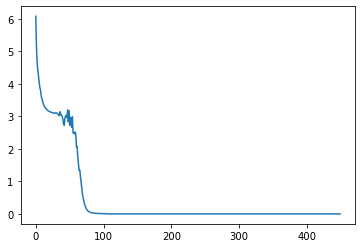

In [13]:
plt.plot(train_losses)

In [15]:
# Check if each instrument can reconstruct its part, given the other instrument's part
min_time_shift = 0.01
time_start = 2*num_notes + num_velocities # Any message greater than this is a time shift message
model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

for inst in range(max_instruments):
    gen_history = history.clone()
    gen_mask = mask.clone()
    gen_times = times.clone()

    gen_idx = torch.tensor([inst], dtype=torch.long)
    
    seq_length = min(recording[inst].shape[0], max_seq_length)

    # Move forward in time
    wrong_cnt = 0
    for t in range(1, seq_length):
        cur_times = torch.gather(gen_times[t], 0, gen_idx.view(1, -1)).unsqueeze(0)
        cur_mask = torch.logical_or(gen_mask, gen_times > cur_times.expand(max_seq_length, max_instruments, -1))
        for seq in range(batch_size):
            cur_mask[t:, gen_idx[seq], seq] = True
                
        probs = torch.nn.functional.softmax(model(gen_history, cur_mask, instruments, gen_idx, t), dim=1)
        gen_history[t, gen_idx, 0] = torch.multinomial(probs, 1).view(1, 1)
        if torch.argmax(probs.flatten()) != history[t, gen_idx].flatten():
            wrong_cnt += 1
            print(torch.topk(probs.flatten(), 10))
            print(history[t, gen_idx])
            
        # If it's a time shift message, update time of next message accordingly
        if t < seq_length - 1 and gen_history[t, gen_idx, 0] >= time_start:
            gen_times[t + 1, gen_idx, 0] = gen_times[t, gen_idx, 0] + min_time_shift*(gen_history[t, gen_idx, 0] + 1)

    print(wrong_cnt)

0
0


In [26]:
# Check if the instruments can jointly reconstruct the piece
min_time_shift = 0.01
time_start = 2*num_notes + num_velocities # Any message greater than this is a time shift message

gen_history = history.clone()
gen_times = times.clone()
gen_times[1:] = float('inf')

model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

wrong_cnt = 0

ts = [1 for inst in range(max_instruments)]

# List of instruments who haven't generated 100 messages yet
incomplete = list(range(max_instruments))

while incomplete:
    print(ts)
    # Find instrument who's most behind
    gen_idx = incomplete[0]
    gen_time = gen_times[ts[gen_idx], gen_idx]
    for inst in incomplete:
        if gen_times[ts[inst], inst] < gen_time:
            gen_time = gen_times[ts[inst], inst]
            gen_idx = inst
            
    t = ts[gen_idx]
    gen_idx = torch.tensor([gen_idx], dtype=torch.long)
    gen_time = torch.tensor(gen_time).view(1, 1, 1)
    cur_mask = gen_times > gen_time.expand(max_seq_length, max_instruments, -1)
    cur_mask[t:, gen_idx] = True

    probs = torch.nn.functional.softmax(model(gen_history, cur_mask, instruments, gen_idx, t), dim=1)
    gen_history[t, gen_idx, 0] = torch.multinomial(probs, 1).view(1, 1)

    # If it's a time shift message, update time of next message accordingly
    if t < max_seq_length - 1 and gen_history[t, gen_idx, 0] >= time_start:
        gen_times[t + 1, gen_idx, 0] = gen_times[t, gen_idx, 0] + min_time_shift*(gen_history[t, gen_idx, 0] + 1)
        
    t += 1
    if t >= max_seq_length:
        incomplete.remove(gen_idx)
    
    ts[gen_idx.item()] = t

[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]

KeyboardInterrupt: 

# Custom dataset class

In [250]:
# Custom Dataset class
class MIDIDataset(torch.utils.data.Dataset):
    # CONSTRUCTOR: creates a list of recording files and a list
    # of instrument files in root_dir. Assumes that the directory
    # contains recording0.npy to recordingM.npy,
    # as well as instruments0.npy to instrumentsM.npy
    # ARGUMENTS
    # root_dir: the directory to search
    def __init__(self, root_dir, transform=None):
        files = os.listdir(root_dir)
        self.recordings = []
        self.instrument_files = []
        self.time_files = []
        for file in files:
            if 'recording' in file:
                self.recordings.append(os.path.join(root_dir, file))
            elif 'instruments' in file:
                self.instrument_files.append(os.path.join(root_dir, file))
            elif 'times' in file:
                self.time_files.append(os.path.join(root_dir, file))
                
        assert(len(self.recordings) == len(self.instrument_files))
        assert(len(self.recordings) == len(self.time_files))
        self.recordings.sort()
        self.instrument_files.sort()
        self.time_files.sort()
        self.transform = transform

    # __len__
    # RETURN: the number of recording files in the dataset
    def __len__(self):
        return len(self.recordings)

    # __getitem__
    # ARGUMENTS
    # idx: indicates which file to get
    # RETURN: an instance with keys 'instruments', 'history', and 'times'
    # instance['history'] is a numpy array of message sequences for each instrument
    # instance['instruments'] a numpy array of instrument numbers
    # instance['times'] is a numpy array of message time sequences for each instrument
    def __getitem__(self, idx):
        instance = {'history': np.load(self.recordings[idx], allow_pickle=True), \
                    'instruments': np.load(self.instrument_files[idx], allow_pickle=True), \
                    'times': np.load(self.time_files[idx], allow_pickle=True)}
        
        assert(len(instance['history']) == len(instance['times']))
        assert(len(instance['history']) == len(instance['instruments']))
        
        for i in range(len(instance['history'])):
            assert(len(instance['history'][i]) == len(instance['times'][i]))
        
        if self.transform:
            instance = self.transform(instance)
            
        return instance

In [251]:
# collate_fn: takes a list of samples from the dataset and turns them into a batch
# ARGUMENTS
# batch: a list of dictionaries
# RETURN: a sample with keys 'history', 'instruments', 'times', and 'mask'
# sample['history']: an LxNxB tensor containing messages
# sample['instruments']: a 1xNxB tensor containing instrument numbers
# sample['mask']: an LxNxB tensor containing False where a message is
# valid, and True where it isn't (accounts for variable length sequences
# and zero padding)
# sample['times']: an LxNxB tensor containing times of each message
def collate_fn(batch):
    batch_size = len(batch)
    
    # We size our tensors to accomodate the longest sequence and the largest ensemble
    max_instruments = max([len(instance['history']) for instance in batch])
    longest_len = max([max([seq.shape[0] for seq in instance['history']]) for instance in batch])

    sample = {'history': torch.ones((longest_len, max_instruments, batch_size), dtype=torch.long), \
              'instruments': torch.zeros((1, max_instruments, batch_size), dtype=torch.long), \
              'times': torch.zeros((longest_len, max_instruments, batch_size)), \
              'mask': torch.ones((longest_len, max_instruments, batch_size), dtype=torch.bool)}

    for b in range(batch_size):
        instrument_idx = [instrument_numbers.index(inst) for inst in batch[b]['instruments']]
        sample['instruments'][0, :len(instrument_idx), b] = torch.tensor(instrument_idx, dtype=torch.long)
        
        for inst_idx in range(len(batch[b]['history'])):
            seq_length = len(batch[b]['history'][inst_idx])
            sample['history'][:seq_length, inst_idx, b] = torch.tensor(batch[b]['history'][inst_idx], dtype=torch.long)
            sample['mask'][:seq_length, inst_idx, b] = False
            sample['times'][:seq_length, inst_idx, b] = torch.tensor(batch[b]['times'][inst_idx])
            
    return sample

# Train the model

In [252]:
ff_size = 512
heads = 8
attention_layers=  6
embed_dim = 256
grad_clip = 10

model = EnsembleTransformer(message_dim, embed_dim, len(instrument_numbers), heads, attention_layers, ff_size)

for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

In [ ]:
batch_size = 1
learning_rate = 0.001

dataset = MIDIDataset('preprocessed_data')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs) # TODO: train/test split. Can we do this with Dataloader?

model.train()

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    for b, batch in enumerate(dataloader):
        print('Starting iteration %d' %(b))
        max_seq_length = batch['history'].shape[0]
        num_targets = max_seq_length - 1 # Messages start from t = 0, but we start generating at t = 1
        max_instruments = batch['history'].shape[1]
        loss = torch.tensor([0])
        for inst in range(max_instruments):
            # Index of the instrument we want to generate music for (same for each batch element as of now)
            gen_idx = torch.tensor([inst for i in range(batch_size)], dtype=torch.long)
            
            mask = batch['mask']
            
            logits = torch.zeros((num_targets, batch_size, message_dim))

            # Move forward in time
            for t in range(1, max_seq_length):
                # Get current time for each batch element (1x1xB) and mask out messages with a greater time stamp
                times = torch.gather(batch['times'][t], 0, gen_idx.view(1, -1)).unsqueeze(0)
                input_mask = torch.logical_or(mask, batch['times'] > times.expand(max_seq_length, max_instruments, -1))
                for seq in range(batch_size):
                    input_mask[t:, gen_idx[seq], seq] = True
                
                logits[t - 1] = model(batch['history'], input_mask, batch['instruments'], gen_idx, t)
                
            logits = logits.view(-1, message_dim)
            target_messages = torch.gather(batch['history'][1:], 1, gen_idx.view(1, 1, -1).expand(num_targets, -1, -1)).flatten()
            output_mask = torch.gather(mask[1:], 1, gen_idx.view(1, 1, -1).expand(num_targets, -1, -1)).flatten()
            loss += loss_fn(logits[output_mask], target_messages[output_mask])
        
        loss /= max_instruments
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses[epoch] += loss.data

# Sample from the model

In [44]:
model.eval() # Disable dropout to make results repeatable